In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from sklearn.metrics import average_precision_score

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
torch.manual_seed(1)

### Generate data

In [3]:
def generate_normal_series(number, mean):
    data = []
    labels = []
    for i in range(number):
        x = []
        label = []
        x_prev = 0
        coef = 0.75
        length = scipy.stats.randint.rvs(50, 200)
        for l in range(length):
            x_curr = coef*x_prev + (1 - coef)*norm.rvs(loc=mean, scale=1)
            x.append(x_curr)
            x_prev = x_curr
            label.append(0)
        data.append(np.asarray(x))
        labels.append(np.asarray(label))
    return data, labels

In [4]:
number_normal = 500
data_normal, labels_normal = generate_normal_series(number_normal, 0)

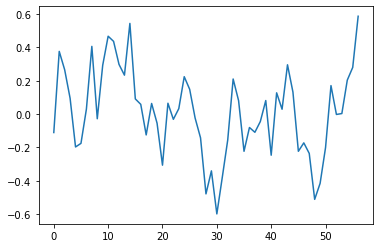

In [5]:
plt.plot(data_normal[0])

In [6]:
def generate_anomaly_series(number, mean_old, mean_new):
    data = []
    labels = []
    for i in range(number):
        x = []
        label = []
        x_prev = 0
        coef = 0.75
        length = scipy.stats.randint.rvs(50, 200)
        chane_point = scipy.stats.randint.rvs(10, length-20)
        for l in range(length):
            if l < chane_point:
                x_curr = coef*x_prev + (1 - coef)*norm.rvs(loc=mean_old, scale=1)
                label.append(0)
                
            else:
                x_curr = coef*x_prev + (1 - coef)*norm.rvs(loc=mean_new, scale=1)
                label.append(1)
            x.append(x_curr)
            x_prev = x_curr
        data.append(np.asarray(x))
        labels.append(np.asarray(label))
    return data, labels

In [7]:
number_anomaly = 200
data_anomaly, labels_anomaly = generate_anomaly_series(number_anomaly, 0, 5)

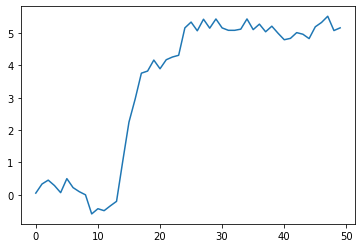

In [8]:
plt.plot(data_anomaly[0])

In [9]:
all_ts_data = np.asarray(data_normal + data_anomaly)
all_labels = np.asarray(labels_normal + labels_anomaly)

In [10]:
ts_train, ts_val, label_train, label_val = train_test_split(all_ts_data, all_labels, 
                                                            test_size=0.25, shuffle=True,
                                                            random_state=42)

In [11]:
test_number_normal = 200
test_data_normal, test_labels_normal = generate_normal_series(test_number_normal, 0)

test_number_anomaly = 10
test_data_anomaly, test_labels_anomaly = generate_anomaly_series(test_number_anomaly, 0, 5)

test_data = np.asarray(test_data_normal + test_data_anomaly)
test_labels = np.asarray(test_labels_normal + test_labels_anomaly)

In [12]:
def create_sequences(ts, label, tw):
    inout_seq = []
    for t in range(len(ts)):
        curr_ts = torch.FloatTensor(ts[t]).view(-1)
        curr_label = torch.IntTensor(label[t]).view(-1)
        for i in range(len(curr_ts) - tw):
            train_seq = curr_ts[i:i+tw]
            train_label = curr_label[i:i+tw]
            inout_seq.append((train_seq ,train_label))
    return inout_seq

### Experiment №2. 
Each moment of time is corresponded to label at the end. Use LSTM and CustomLoss()

#### Loss function

In [13]:
def loss_delay_detection_2(p_slice):
    n = p_slice.size(0)
    prod = torch.ones(n)
    prod[1:] -= p_slice[:-1]
    cumprod = torch.cumprod(prod, dim=0)
    loss = torch.arange(1, n+1) * p_slice * cumprod
    loss = torch.sum(loss)
    return loss


def loss_delay_detection(p_slice, w):
    n = p_slice.size(0)
    prod = torch.ones(n)
    prod[1:] -= p_slice[:-1]
    cumprod = torch.cumprod(prod, dim=0)
    loss = torch.arange(1, n+1) * p_slice * cumprod  + (w + 1)*torch.prod(prod[1:])*(1 - p_slice[-1])
    loss = torch.sum(loss)
    return loss

def loss_false_alarms_i(p_slice):
    n = p_slice.size(0)
    prod = torch.ones(n)
    prod[1:] -= p_slice[:-1]
    cumprod = torch.cumprod(prod, dim=0)
    loss = p_slice * cumprod
    loss = torch.sum(loss)
    return loss

def loss_false_alarms(p_slice, l = 4):
    length = len(p_slice)
    loss = 0
    for i in range(0, l):
        ind = i*(length//l)
        loss += 1 - loss_delay_detection_2(p_slice[ind: ind + length//l])
    loss = torch.sum(loss)
    return loss

In [14]:
def loss_false_alarms_i(p_slice):
    n = p_slice.size(0)
    prod = torch.ones(n)
    prod[1:] -= p_slice[:-1]
    cumprod = torch.cumprod(prod, dim=0)
    loss = p_slice * cumprod
    print(loss)
    #loss = torch.sum(loss)
    return loss, prod, cumprod

In [24]:
class CustomLoss(nn.Module):
    
    def __init__(self):
        super(CustomLoss, self).__init__()
        
    def forward(self, outputs, labels):
        loss = torch.zeros(labels.size(0))
        for i, label in enumerate(labels):

            ind = torch.where(label != label[0])[0]
            if ind.size()[0] == 0:
                #loss[i] = 1 - loss_delay_detection_2(outputs[i,:])   
                #shift = 32
                #loss[i] = loss[i] + 1 - loss_delay_detection_2(outputs[i, shift:])
                loss[i] = loss_false_alarms(outputs[i, :])
            else:
                w = 16
                loss[i] = loss_delay_detection(outputs[i, ind[0]: ind[0] + w], w)
        loss = torch.mean(loss)
        return loss

In [25]:
# input data parameters
input_size = 64
output_size = 64

# model hyperparameters
batch_size = 128
hidden_dim = 10
n_layers = 2
num_workers = 1
learning_rate = 1e-3

In [26]:
# prepare data in right format for LSTM

train_inout_seq = create_sequences(ts_train, label_train, input_size)
test_inout_seq = create_sequences(test_data, test_labels, input_size)
val_inout_seq = create_sequences(ts_val, label_val, input_size)

train_inout_seq = train_inout_seq[:-(len(train_inout_seq)%batch_size)]
test_inout_seq = test_inout_seq[:-(len(test_inout_seq)%batch_size)]
val_inout_seq = val_inout_seq[:-(len(val_inout_seq)%batch_size)]

train_loader = DataLoader(train_inout_seq, batch_size=batch_size, shuffle=False, num_workers=num_workers)
val_loader = DataLoader(val_inout_seq, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_inout_seq, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [27]:
train_inout_seq

[(tensor([-0.2654, -0.2006, -0.6414, -0.7644, -0.5643, -0.6388, -0.4825,  0.0464,
          -0.1778, -0.6418, -0.3632, -0.5396, -0.3614, -0.6171, -0.8234, -0.7009,
          -0.6817, -0.5550, -0.7900, -0.8103, -0.5876, -0.5382, -0.3738, -0.3179,
          -0.4728,  0.0065,  0.1881,  0.2080, -0.0602, -0.1095,  0.0719,  0.0381,
           0.0103, -0.3554, -0.2569, -0.5847, -0.8726, -0.7438, -0.6757, -0.2054,
          -0.3386, -0.1659, -0.3532, -0.7086, -0.4903, -0.1564, -0.4758,  0.0747,
          -0.0465, -0.3749,  0.0647,  0.0999,  0.1570, -0.2391, -0.0230, -0.0318,
           0.4248,  0.5384,  0.4296,  0.0863,  0.3049,  0.5689,  0.6114,  0.3518]),
  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.int32)),
 (tensor([-0.2006, -0.6414, -0.7644, -0.5643, -0.6388, -0.4825,  0.0464, -0.1778,
          -0.641

In [28]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, drop_prob=0.5):
        
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.linear = nn.Linear(hidden_dim, output_size)
        self.activation = nn.Sigmoid()
        
    def forward(self, input_seq, hidden):
        batch_size = input_seq.size(0)
        lstm_out, hidden = self.lstm(input_seq[:, None, :], hidden)        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)        

        out = self.dropout(lstm_out)
        out = self.linear(out)
        out = self.activation(out)
        out = out.view(batch_size, -1)
        return out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [29]:
device = torch.device("cpu")

In [30]:
model = LSTM(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_function = CustomLoss()

In [31]:
test_inout_seq[-100:]

[(tensor([-0.3739, -0.2476, -0.1335,  0.1604, -0.2381,  0.1532,  0.1540, -0.0473,
          -0.1358,  0.2141,  0.1711,  0.0829, -0.0772, -0.1190,  0.2884,  0.4227,
           0.3169,  0.1435, -0.1323,  0.1907,  0.0196, -0.1124, -0.0426,  0.4260,
           0.6463,  0.2777, -0.0204,  0.2986,  0.3172, -0.0505,  0.2383,  0.3872,
           0.2047,  0.2710,  0.1359,  0.3293,  0.1351,  0.0550,  0.0384,  0.3095,
           0.8415,  1.0466,  0.5155,  0.6610,  0.8618,  0.4656,  0.2317, -0.1679,
          -0.3147, -0.6718, -0.7034, -0.5303, -0.5781, -1.0157, -0.8257, -0.6950,
          -0.6582, -0.3435, -0.1480,  0.0738,  0.3305,  0.1691,  0.4788,  0.2700]),
  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.int32)),
 (tensor([-0.2476, -0.1335,  0.1604, -0.2381,  0.1532,  0.1540, -0.0473, -0.1358,
           0.214

In [32]:
epochs = 5
print_every = 100
valid_loss_min = np.Inf

loss_list = []
acc_list = []
counter = 0
model.train()

for i in range(epochs):
    
    for inputs, labels in tqdm(train_loader):
        counter += 1
        h = model.init_hidden(batch_size)
        h = tuple([e.data for e in h])
        inputs, labels = inputs.to(device), labels.to(device)        
        model.zero_grad()
        optimizer.zero_grad()
        output, h = model(inputs, h)
        loss = loss_function(output.squeeze(), labels.float())
        
        loss_list += [loss.clone().detach()]
        accuracy = (output > 0.5).long() == labels
        acc_list += [accuracy.detach().float().mean()]
        
        loss.backward()
        optimizer.step()
        
        if counter%print_every == 0:
            val_losses = []
            val_outputs = []
            model.eval()
            for val_inputs, val_labels in val_loader:
                val_h = model.init_hidden(batch_size)
                val_h = tuple([each.data for each in val_h])
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                
                val_out, val_h = model(val_inputs, val_h)
                val_loss = loss_function(val_out.squeeze(), val_labels.float())
                val_losses.append(val_loss.item())
                val_outputs += [val_out.clone().detach()]
                
            val_outputs_one = torch.cat(val_outputs, 0)
            model.train()
            print("Epoch: {}/{}...".format(i+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))
        

Epoch: 1/5... Step: 100... Loss: -4.991335... Val Loss: -4.168569
Epoch: 1/5... Step: 200... Loss: -7.961777... Val Loss: -11.192681



Epoch: 2/5... Step: 300... Loss: -33.976307... Val Loss: -32.829721
Epoch: 2/5... Step: 400... Loss: -44.732933... Val Loss: -43.119060
Epoch: 2/5... Step: 500... Loss: -48.816353... Val Loss: -47.208556



Epoch: 3/5... Step: 600... Loss: -53.381565... Val Loss: -49.031786
Epoch: 3/5... Step: 700... Loss: -49.097664... Val Loss: -50.182894



Epoch: 4/5... Step: 800... Loss: -36.723133... Val Loss: -51.445685
Epoch: 4/5... Step: 900... Loss: -56.601147... Val Loss: -51.940122
Epoch: 4/5... Step: 1000... Loss: -44.717842... Val Loss: -52.143513



Epoch: 5/5... Step: 1100... Loss: -57.918461... Val Loss: -52.379736
Epoch: 5/5... Step: 1200... Loss: -57.799114... Val Loss: -52.483771



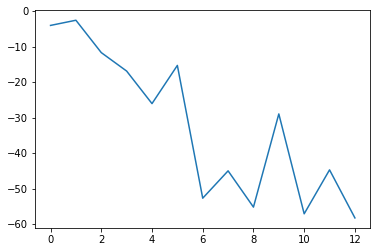

In [33]:
plt.plot(loss_list[::100])

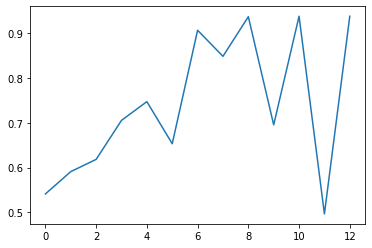

In [34]:
plt.plot(acc_list[::100])

In [35]:
test_loss_list = []
test_acc_list = []
test_pr_list = []

model.eval()
for test_inputs, test_labels in test_loader:
    test_h = model.init_hidden(batch_size)
    test_h = tuple([each.data for each in test_h])
    test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
    test_output, test_h = model(test_inputs, test_h)
    test_loss = loss_function(test_output.squeeze(), test_labels.float())
    test_loss_list += [test_loss.clone().detach()]
    
    accuracy = (test_output > 0.5).long() == test_labels
    #pr_auc = average_precision_score(test_labels.detach().numpy(), test_output.detach().numpy())
    test_acc_list += [accuracy.detach().float().mean()]
    #test_pr_list += [pr_auc]
    
print("Test loss: {:.3f}".format(np.mean(test_loss_list)))
print("Test accuracy: {:.3f}%".format(np.mean(test_acc_list)))
#print("Test PR_AUC: {:.3f}%".format(np.mean(test_pr_list)))

Test loss: -57.892
Test accuracy: 0.908%


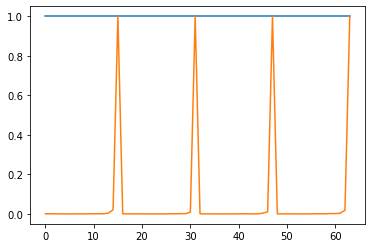

In [44]:
ind = -1
plt.plot(test_labels[ind].detach().numpy())
plt.plot(test_output[ind].detach().numpy())

In [43]:
test_labels

tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)

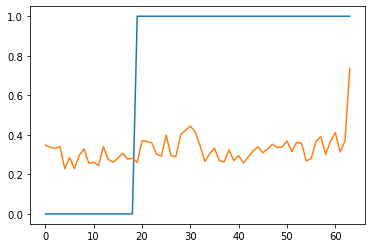

In [50]:
#38
ind = 17
plt.plot(test_labels[ind].detach().numpy());
plt.plot(test_output[ind].detach().numpy());

In [102]:
test_output[ind]

tensor([3.4980e-04, 5.5307e-04, 2.8701e-04, 3.7354e-04, 3.4185e-04, 2.3890e-04,
        1.8988e-04, 2.4908e-04, 4.4443e-04, 4.1230e-04, 8.0745e-04, 9.0720e-04,
        8.0815e-04, 1.4572e-03, 1.5538e-03, 2.1027e-03, 2.0061e-02, 5.4302e-03,
        9.1797e-03, 6.9392e-03, 8.2979e-03, 1.5117e-02, 1.3962e-02, 1.9079e-02,
        3.7284e-02, 6.3291e-02, 1.3903e-01, 2.9194e-01, 6.6620e-01, 9.4613e-01,
        9.5428e-01, 9.7152e-01, 9.4618e-01, 9.1990e-01, 9.2494e-01, 9.3424e-01,
        9.3627e-01, 9.5517e-01, 9.4644e-01, 9.5830e-01, 9.6235e-01, 9.2535e-01,
        9.5420e-01, 9.5226e-01, 9.5779e-01, 9.6811e-01, 9.5981e-01, 9.6759e-01,
        9.6089e-01, 9.4863e-01, 9.5305e-01, 9.6747e-01, 9.5396e-01, 9.6147e-01,
        9.1342e-01, 9.3914e-01, 9.4897e-01, 9.5447e-01, 9.4537e-01, 8.9927e-01,
        8.7765e-01, 9.0865e-01, 9.4826e-01, 9.6814e-01],
       grad_fn=<SelectBackward>)

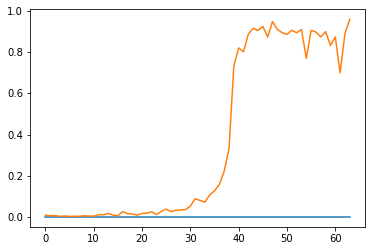

In [48]:
plt.plot(labels[1].detach().numpy())
plt.plot(output[1].detach().numpy())

In [45]:
labels[30:40]

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 